# Trajectory Analysis

This notebook generates trajectory visualization plots for detailed analysis of policy behavior.

**Features:**
- Runs `wandb_eval.py` via subprocess if trajectory data doesn't exist
- Multi-panel trajectory plots with phase annotations
- Break analysis by phase
- Selection confidence comparison
- Selection probability trajectories by phase

In [6]:
# ============================================================
# BLOCK 1: IMPORTS & CONSTANTS
# ============================================================

import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import pickle
import subprocess
import os
import sys
from pathlib import Path
from collections import defaultdict
from typing import Dict, List, Tuple, Optional, Union

# WandB Configuration
ENTITY = "hur"
PROJECT = "SG_Exps"

# Method Tags - internal name -> wandb tag
METHOD_TAGS = {
    #"Pose(1mm)": "pose_task_frag:2026-01-06_00:52",
    #"Pose(2.5mm)" : "pose_25mm-noise:2026-01-19_07:50_15N",
    #"Pose-7.5mm":"pose_75mm-noise:2026-01-17_19:18",
    #"MATCH(1mm)": "LCLoP_task_frag:2026-01-06_00:27",
    #"Hybrid-Basic(1mm)": "basic-hybrid_task_frag:2026-01-06_00:56",

    # hex
    #"Pose": "pose_hex:2026-01-13_22:49",
    #"SWISH": "LCLoP_hex:2026-01-13_22:49",


    #"Pose(1mm)": "pose_base-case:2026-02-02_13:40",
    #"Pose(2.5mm)": "pose_25mm:2026-02-02_13:40",
    #"MATCH(1mm)": "MATCH_base-case:2026-02-04_17:46",
    #"Hybrid-Basic(1mm)": "basic-hybrid_base-case:2026-02-02_13:40",

    #Pose(1mm)": "pose_breakable_f10N:2026-02-04_17:49",
    #"Pose(2.5mm)": "pose_25mm_f10:2026-02-05_22:12",
    #"MATCH(1mm)": "MATCH_breakable_10N:2026-02-04_17:49",
    #"Hybrid-Basic(1mm)": "basic-hybrid_breakable_f10N:2026-02-04_17:49",


    #"VIC":  "pose_vic_squashed_breakable_f10:2026-02-21_10:59",
    #"Pose-1": "pose_squashed_breakable_f10:2026-02-21_10:59",
    "MATCH": "MATCH_squashed_breakable_f10:2026-02-21_10:59",
    "Hybrid": "hybrid_squashed_breakable_f10:2026-02-21_10:59",
}

# Method display settings
METHOD_COLORS = {
    "Pose(1mm)": "#2ca02c",        # Green
    "Hybrid-Basic": "#ff7f0e", # Orange
    "MATCH(1mm)": "#1f77b4",       # Blue
}

# Evaluation Tags
TAG_EVAL_PERFORMANCE = "eval_performance"

# Metrics for best policy selection
METRIC_SUCCESS = "num_successful_completions"
METRIC_BREAKS = "num_breaks"

# Trajectory Evaluation Configuration
WANDB_EVAL_SCRIPT = "../../eval/wandb_eval.py"  # Relative to this notebook
TRAJ_OUTPUT_BASE = "../../eval/traj_data"  # Base directory for trajectory data

# Phase definitions (matching traj_vis.ipynb)
PHASES = ['approaching', 'initial_contact', 'insertion']
PHASE_COLORS = {
    'approaching': '#90EE90',      # Light green
    'initial_contact': '#FFD700',  # Gold
    'insertion': '#87CEEB',        # Sky blue
}

# Outcome definitions
OUTCOMES = ['success', 'break', 'timeout']

In [7]:
# ============================================================
# BLOCK 2: DETERMINE BEST POLICY
# ============================================================

def get_best_checkpoint_per_run(api, method_tag):
    """
    Find the best checkpoint for each training run based on eval_performance runs.
    
    Returns dict mapping training_run_id -> {run_name, best_step, score, eval_run_id}
    """
    # Query eval runs
    eval_runs = api.runs(
        f"{ENTITY}/{PROJECT}",
        filters={"$and": [{"tags": method_tag}, {"tags": TAG_EVAL_PERFORMANCE}]}
    )
    
    # Query training runs (have method_tag but NOT eval_performance)
    training_runs = api.runs(
        f"{ENTITY}/{PROJECT}",
        filters={"$and": [{"tags": method_tag}, {"tags": {"$ne": TAG_EVAL_PERFORMANCE}}]}
    )
    
    # Build lookup: training run name -> training run id
    training_run_lookup = {}
    for run in training_runs:
        training_run_lookup[run.name] = run.id
    
    print(f"  Found {len(training_run_lookup)} training runs")
    
    best_checkpoints = {}
    for eval_run in eval_runs:
        history = eval_run.history()
        if history.empty:
            print(f"  Warning: Eval run {eval_run.name} has no history data")
            continue
        
        # Calculate score: successes - breaks
        history["score"] = history[f"Eval_Core/{METRIC_SUCCESS}"] - history[f"Eval_Core/{METRIC_BREAKS}"]
        best_idx = history["score"].idxmax()
        best_step = int(history.loc[best_idx, "total_steps"])
        
        # Extract training run name from eval run name
        # Eval run: "Eval_performance_pose_perf-comp_f(10)_0"
        # Training run: "pose_perf-comp_f(10)_0"
        eval_run_name = eval_run.name
        if eval_run_name.startswith("Eval_performance_"):
            training_run_name = eval_run_name[len("Eval_performance_"):]
        elif eval_run_name.startswith("Eval_noise_"):
            training_run_name = eval_run_name[len("Eval_noise_"):]
        else:
            # Try to find a matching training run by suffix
            training_run_name = eval_run_name
        
        # Look up training run ID
        if training_run_name not in training_run_lookup:
            print(f"  Warning: Could not find training run for eval run {eval_run_name}")
            print(f"    Expected training run name: {training_run_name}")
            continue
        
        training_run_id = training_run_lookup[training_run_name]
        
        best_checkpoints[training_run_id] = {
            "run_name": training_run_name,
            "best_step": best_step,
            "score": history.loc[best_idx, "score"],
            "eval_run_id": eval_run.id,
            "eval_run_name": eval_run_name,
        }
        print(f"    {training_run_name} (train:{training_run_id}): best checkpoint at step {best_step} (score: {history.loc[best_idx, 'score']:.0f})")
    
    return best_checkpoints

# Get best checkpoints for each method
api = wandb.Api()
best_checkpoints = {}  # best_checkpoints[method]

for method_name, method_tag in METHOD_TAGS.items():
    print(f"\n{'='*60}")
    print(f"Method: {method_name} ({method_tag})")
    print(f"{'='*60}")
    best_checkpoints[method_name] = get_best_checkpoint_per_run(api, method_tag)


Method: MATCH (MATCH_squashed_breakable_f10:2026-02-21_10:59)
  Found 10 training runs
    MATCH_squashed_breakable_f(10)_0 (train:cfonbefc): best checkpoint at step 1497600 (score: 98)
    MATCH_squashed_breakable_f(10)_3 (train:0ms1il9d): best checkpoint at step 2572800 (score: 98)
    MATCH_squashed_breakable_f(10)_1 (train:ai09st92): best checkpoint at step 2726400 (score: 97)
    MATCH_squashed_breakable_f(10)_2 (train:2xwwtxtt): best checkpoint at step 998400 (score: 94)
    MATCH_squashed_breakable_f(10)_4 (train:e32ueab6): best checkpoint at step 998400 (score: 98)

Method: Hybrid (hybrid_squashed_breakable_f10:2026-02-21_10:59)
  Found 10 training runs
    hybrid_squashed_breakable_f(10)_0 (train:q5qtlp6b): best checkpoint at step 2956800 (score: 99)
    hybrid_squashed_breakable_f(10)_1 (train:brsf94pp): best checkpoint at step 1420800 (score: 98)
    hybrid_squashed_breakable_f(10)_2 (train:gm0nq0dx): best checkpoint at step 2956800 (score: 96)
    hybrid_squashed_breakable

In [8]:
# ============================================================
# BLOCK 3: RUN TRAJECTORY EVALUATION (IF NEEDED)
# ============================================================

# Get absolute paths for the script and output directory
NOTEBOOK_DIR = os.path.dirname(os.path.abspath("__file__"))
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, "../.."))
WANDB_EVAL_SCRIPT_ABS = os.path.join(PROJECT_ROOT, "eval/wandb_eval.py")
TRAJ_OUTPUT_BASE_ABS = os.path.join(PROJECT_ROOT, "eval/traj_data")

print(f"Project root: {PROJECT_ROOT}")
print(f"Eval script: {WANDB_EVAL_SCRIPT_ABS}")
print(f"Output base: {TRAJ_OUTPUT_BASE_ABS}")


def get_traj_output_path(method_tag: str) -> str:
    """Get the output directory for trajectory data for a method."""
    # Format: {base}/{tag}/
    safe_tag = method_tag.replace(":", "_").replace("/", "_")
    return os.path.join(TRAJ_OUTPUT_BASE_ABS, safe_tag)


def check_run_data_exists(output_dir: str, run_id: str, checkpoint: int) -> bool:
    """Check if trajectory data exists for a specific run and checkpoint."""
    run_dir = os.path.join(output_dir, run_id)
    if not os.path.exists(run_dir):
        return False
    
    # Check for the specific checkpoint pkl file
    pkl_file = f"traj_{checkpoint}.pkl"
    return os.path.exists(os.path.join(run_dir, pkl_file))


def run_trajectory_eval(
    method_tag: str,
    checkpoint: int,
    output_dir: str,
    run_id: str,
    dry_run: bool = False
) -> bool:
    """
    Run wandb_eval.py with trajectory mode for a specific run and checkpoint.
    
    Args:
        method_tag: WandB tag for the method
        checkpoint: Checkpoint step to evaluate
        output_dir: Directory to save trajectory data
        run_id: Specific run ID to evaluate
        dry_run: If True, print command without executing
        
    Returns:
        True if successful, False otherwise
    """
    cmd = [
        sys.executable, WANDB_EVAL_SCRIPT_ABS,
        "--tag", method_tag,
        "--checkpoint", str(checkpoint),
        "--eval_mode", "trajectory",
        "--traj_output_dir", output_dir,
        "--entity", ENTITY,
        "--project", PROJECT,
        "--run_id", run_id,
    ]
    
    print(f"\nCommand: {' '.join(cmd)}")
    print(f"Working directory: {PROJECT_ROOT}")
    
    if dry_run:
        print("[DRY RUN] Would execute above command")
        return True
    
    try:
        # Set up environment with PYTHONPATH including project root
        env = os.environ.copy()
        pythonpath = env.get('PYTHONPATH', '')
        if pythonpath:
            env['PYTHONPATH'] = f"{PROJECT_ROOT}:{pythonpath}"
        else:
            env['PYTHONPATH'] = PROJECT_ROOT
        
        print(f"PYTHONPATH: {env['PYTHONPATH']}")
        
        # Use Popen to stream output in real-time
        print("\n" + "-"*60)
        print(f"Starting trajectory evaluation for {run_id} at checkpoint {checkpoint}...")
        print("-"*60 + "\n")
        
        process = subprocess.Popen(
            cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            text=True,
            bufsize=1,
            universal_newlines=True,
            cwd=PROJECT_ROOT,
            env=env,
        )
        
        # Stream output line by line
        output_lines = []
        for line in process.stdout:
            print(line, end='')
            output_lines.append(line)
        
        # Wait for process to complete
        return_code = process.wait()
        
        # Check for Python exceptions
        output_text = ''.join(output_lines)
        has_python_exception = 'Traceback (most recent call last):' in output_text
        has_module_error = 'ModuleNotFoundError:' in output_text
        
        # Check for success indicators
        has_success = 'Evaluation complete!' in output_text or 'Saved trajectory data' in output_text
        
        print("\n" + "-"*60)
        if return_code != 0:
            print(f"Trajectory evaluation FAILED with return code: {return_code}")
            return False
        elif has_python_exception or has_module_error:
            print(f"Trajectory evaluation FAILED (Python exception detected)")
            return False
        elif has_success:
            print("Trajectory evaluation completed successfully!")
            return True
        else:
            print("Trajectory evaluation completed (no explicit success/failure detected)")
            return True
            
    except subprocess.TimeoutExpired:
        print("Trajectory evaluation timed out after 1 hour")
        process.kill()
        return False
    except Exception as e:
        print(f"Exception running trajectory eval: {e}")
        import traceback
        traceback.print_exc()
        return False


# Configuration for this run
DRY_RUN = False  # Set to False to actually run evaluations
FORCE_RERUN = False  # Set to True to re-run even if data exists

# Check and run trajectory evaluations for each run at its own best checkpoint
# Process ONE RUN AT A TIME to avoid multiple Isaac Sim instances
traj_data_paths = {}  # traj_data_paths[method] = output_dir

methods_to_process = list(METHOD_TAGS.items())
evaluation_failed = False

for method_name, method_tag in methods_to_process:
    print(f"\n{'='*60}")
    print(f"Processing: {method_name}")
    print(f"{'='*60}")
    
    method_checkpoints = best_checkpoints.get(method_name, {})
    if not method_checkpoints:
        print(f"  No checkpoints found for {method_name}")
        continue
    
    # Output directory is per-method (not per-checkpoint)
    output_dir = get_traj_output_path(method_tag)
    traj_data_paths[method_name] = output_dir
    
    # Process each run individually at its own best checkpoint
    for run_id, run_info in method_checkpoints.items():
        run_name = run_info["run_name"]
        best_step = run_info["best_step"]
        score = run_info["score"]
        
        print(f"\n  Run: {run_name} (id: {run_id})")
        print(f"    Best checkpoint: {best_step} (score: {score})")
        
        # Check if data already exists for this run
        if check_run_data_exists(output_dir, run_id, best_step) and not FORCE_RERUN:
            print(f"    Data exists, skipping")
            continue
        
        print(f"    Running trajectory evaluation...")
        
        success = run_trajectory_eval(
            method_tag, best_step, output_dir, run_id, dry_run=DRY_RUN
        )
        
        if not success and not DRY_RUN:
            print(f"\n  WARNING: Evaluation failed for {run_name}")
            print(f"  Stopping to avoid repeated failures.")
            evaluation_failed = True
            break
    
    if evaluation_failed:
        break

# Summary
print("\n" + "="*60)
print("TRAJECTORY DATA SUMMARY")
print("="*60)

for method_name, output_dir in traj_data_paths.items():
    print(f"\n{method_name}:")
    print(f"  Path: {output_dir}")
    
    if not os.path.exists(output_dir):
        print(f"  Status: MISSING (no data)")
        continue
    
    method_checkpoints = best_checkpoints.get(method_name, {})
    total_runs = len(method_checkpoints)
    found_runs = 0
    
    for run_id, run_info in method_checkpoints.items():
        best_step = run_info["best_step"]
        exists = check_run_data_exists(output_dir, run_id, best_step)
        status = "OK" if exists else "MISSING"
        if exists:
            found_runs += 1
        print(f"    {run_info['run_name']}: checkpoint {best_step} [{status}]")
    
    print(f"  Total: {found_runs}/{total_runs} runs have data")

Project root: /home/hunter/Continuous_Force_RL
Eval script: /home/hunter/Continuous_Force_RL/eval/wandb_eval.py
Output base: /home/hunter/Continuous_Force_RL/eval/traj_data

Processing: MATCH

  Run: MATCH_squashed_breakable_f(10)_0 (id: cfonbefc)
    Best checkpoint: 1497600 (score: 98)
    Data exists, skipping

  Run: MATCH_squashed_breakable_f(10)_3 (id: 0ms1il9d)
    Best checkpoint: 2572800 (score: 98)
    Data exists, skipping

  Run: MATCH_squashed_breakable_f(10)_1 (id: ai09st92)
    Best checkpoint: 2726400 (score: 97)
    Data exists, skipping

  Run: MATCH_squashed_breakable_f(10)_2 (id: 2xwwtxtt)
    Best checkpoint: 998400 (score: 94)
    Data exists, skipping

  Run: MATCH_squashed_breakable_f(10)_4 (id: e32ueab6)
    Best checkpoint: 998400 (score: 98)
    Data exists, skipping

Processing: Hybrid

  Run: hybrid_squashed_breakable_f(10)_0 (id: q5qtlp6b)
    Best checkpoint: 2956800 (score: 99)
    Data exists, skipping

  Run: hybrid_squashed_breakable_f(10)_1 (id: brsf

In [9]:
# ============================================================
# BLOCK 4: DATA LOADING FUNCTIONS
# ============================================================

def _standardize_step(step: Dict) -> Dict:
    """
    Ensure step dict has all expected fields with correct format.
    Converts numpy arrays to lists, handles missing fields with defaults.
    """
    field_map = {
        'contact_force': ['contact_force', 'force', 'wrench'],
        'contact_state': ['contact_state', 'in_contact', 'contact'],
        'control_selection': ['control_selection', 'mode_selection', 'selection'],
        'control_probability': ['control_probability', 'mode_prob', 'selection_prob'],
        'velocity': ['velocity', 'ee_velocity', 'vel'],
        'position_error': ['position_error', 'pos_error', 'pos_err'],
        'force_error': ['force_error', 'f_error', 'force_err'],
        'phase': ['phase'],
        'peg_pos': ['peg_pos', 'ee_pos', 'position'],
        'terminated': ['terminated', 'done', 'terminal'],
        'rewards': ['rewards', 'reward'],
    }
    
    def get_field(data, keys, default=None):
        for k in keys:
            if k in data:
                val = data[k]
                if hasattr(val, 'tolist'):
                    return val.tolist()
                return val
        return default
    
    return {
        'step': step.get('step', 0),
        'phase': get_field(step, field_map['phase'], 'unknown'),
        'contact_force': get_field(step, field_map['contact_force'], [0, 0, 0]),
        'contact_state': get_field(step, field_map['contact_state'], False),
        'control_selection': get_field(step, field_map['control_selection'], [0, 0, 0]),
        'control_probability': get_field(step, field_map['control_probability'], [0.5, 0.5, 0.5]),
        'velocity': get_field(step, field_map['velocity'], [0, 0, 0]),
        'position_error': get_field(step, field_map['position_error'], [0, 0, 0]),
        'force_error': get_field(step, field_map['force_error'], [0, 0, 0]),
        'peg_pos': get_field(step, field_map['peg_pos'], None),
        'terminated': get_field(step, field_map['terminated'], False),
        'rewards': get_field(step, field_map['rewards'], {}),
    }


def _parse_episode(raw_ep: Dict, policy: str, episode_id: str, run_id: str) -> Tuple[Dict, Optional[Dict]]:
    """Parse a single episode into standardized format."""
    steps = raw_ep.get('policy_steps', raw_ep.get('steps', raw_ep.get('trajectory', [])))
    
    hole_pos = raw_ep.get('hole_pos', None)
    initial_peg_pos = raw_ep.get('initial_peg_pos', None)
    
    if hole_pos is not None and hasattr(hole_pos, 'tolist'):
        hole_pos = hole_pos.tolist()
    if initial_peg_pos is not None and hasattr(initial_peg_pos, 'tolist'):
        initial_peg_pos = initial_peg_pos.tolist()
    
    standardized_steps = []
    for s in steps:
        std_step = _standardize_step(s)
        
        # Compute insertion_depth and lateral_error if we have hole_pos and peg_pos
        if hole_pos is not None and std_step.get('peg_pos') is not None:
            peg_pos = std_step['peg_pos']
            std_step['insertion_depth'] = hole_pos[2] - peg_pos[2]
            # Lateral error = XY distance from peg to hole center
            std_step['lateral_error'] = ((peg_pos[0] - hole_pos[0])**2 + (peg_pos[1] - hole_pos[1])**2)**0.5
        
        standardized_steps.append(std_step)
    
    break_sim_steps = raw_ep.get('break_sim_steps', None)
    
    # Infer outcome
    outcome = raw_ep.get('outcome', None)
    if outcome is None:
        outcome = 'success' if any(s.get('terminated', False) for s in steps) else 'timeout'
    
    parsed_episode = {
        'policy': policy,
        'episode_id': episode_id,
        'run_id': run_id,
        'outcome': outcome,
        'steps': standardized_steps,
        'hole_pos': hole_pos,
        'initial_peg_pos': initial_peg_pos,
    }
    
    break_event = None
    if outcome == 'break' and break_sim_steps is not None:
        break_event = {
            'policy': policy,
            'episode_id': episode_id,
            'run_id': run_id,
            'sim_steps': [_standardize_step(s) for s in break_sim_steps]
        }
    
    return parsed_episode, break_event


def load_trajectory_data_for_method(
    output_dir: str,
    policy_name: str,
    method_checkpoints: Dict[str, Dict],
    verbose: bool = True
) -> Tuple[List[Dict], List[Dict]]:
    """
    Load trajectory data from .pkl files for a method.
    
    Each run has its own best checkpoint, so we load the specific pkl file
    for each run based on its checkpoint.
    
    Args:
        output_dir: Directory containing run subdirectories with .pkl files
        policy_name: Name to assign to this policy
        method_checkpoints: Dict mapping run_id -> {run_name, best_step, score}
        verbose: Print loading progress
        
    Returns:
        Tuple of (episode_data, break_events)
    """
    output_dir = os.path.abspath(output_dir)
    
    if not os.path.exists(output_dir):
        if verbose:
            print(f"Warning: Output directory does not exist: {output_dir}")
        return [], []
    
    episode_data = []
    break_events = []
    load_stats = {'runs': 0, 'episodes': 0, 'breaks': 0}
    
    for run_id, run_info in method_checkpoints.items():
        best_step = run_info["best_step"]
        run_dir = os.path.join(output_dir, run_id)
        pkl_file = f"traj_{best_step}.pkl"
        pkl_path = os.path.join(run_dir, pkl_file)
        
        if not os.path.exists(pkl_path):
            if verbose:
                print(f"  Warning: Missing {pkl_file} for run {run_id}")
            continue
        
        try:
            with open(pkl_path, 'rb') as f:
                raw_data = pickle.load(f)
            
            # Parse the trajectory data
            if isinstance(raw_data, dict) and 'trajectories' in raw_data:
                trajectories = raw_data['trajectories']
                for env_key, env_data in trajectories.items():
                    env_idx = int(env_key.replace('env_', ''))
                    episode_id = f"{run_id}_env_{env_idx}"
                    parsed_ep, break_event = _parse_episode(env_data, policy_name, episode_id, run_id)
                    episode_data.append(parsed_ep)
                    load_stats['episodes'] += 1
                    if break_event is not None:
                        break_events.append(break_event)
                        load_stats['breaks'] += 1
            
            load_stats['runs'] += 1
            
        except Exception as e:
            if verbose:
                print(f"  Error loading {pkl_path}: {e}")
    
    if verbose:
        print(f"  Loaded {policy_name}: {load_stats['runs']} runs, {load_stats['episodes']} episodes, {load_stats['breaks']} breaks")
    
    return episode_data, break_events


# Load all trajectory data
all_episode_data = []
all_break_events = []

print("Loading trajectory data...")
for method_name, output_dir in traj_data_paths.items():
    method_checkpoints = best_checkpoints.get(method_name, {})
    episodes, breaks = load_trajectory_data_for_method(
        output_dir, method_name, method_checkpoints
    )
    all_episode_data.extend(episodes)
    all_break_events.extend(breaks)

print(f"\nTotal: {len(all_episode_data)} episodes, {len(all_break_events)} break events")

# Print outcome breakdown
if all_episode_data:
    outcome_counts = defaultdict(lambda: defaultdict(int))
    for ep in all_episode_data:
        outcome_counts[ep['policy']][ep['outcome']] += 1
    
    print("\nOutcome breakdown:")
    for policy in sorted(outcome_counts.keys()):
        counts = outcome_counts[policy]
        print(f"  {policy}: success={counts['success']}, break={counts['break']}, timeout={counts['timeout']}")


Loading trajectory data...
  Loaded MATCH: 5 runs, 500 episodes, 5 breaks
  Loaded Hybrid: 5 runs, 500 episodes, 6 breaks

Total: 1000 episodes, 11 break events

Outcome breakdown:
  Hybrid: success=483, break=6, timeout=11
  MATCH: success=480, break=5, timeout=15


Computed phase proportions from data:
  approaching: 19.6% (avg 9.4 steps)
  initial_contact: 31.6% (avg 15.2 steps)
  insertion: 48.9% (avg 23.5 steps)


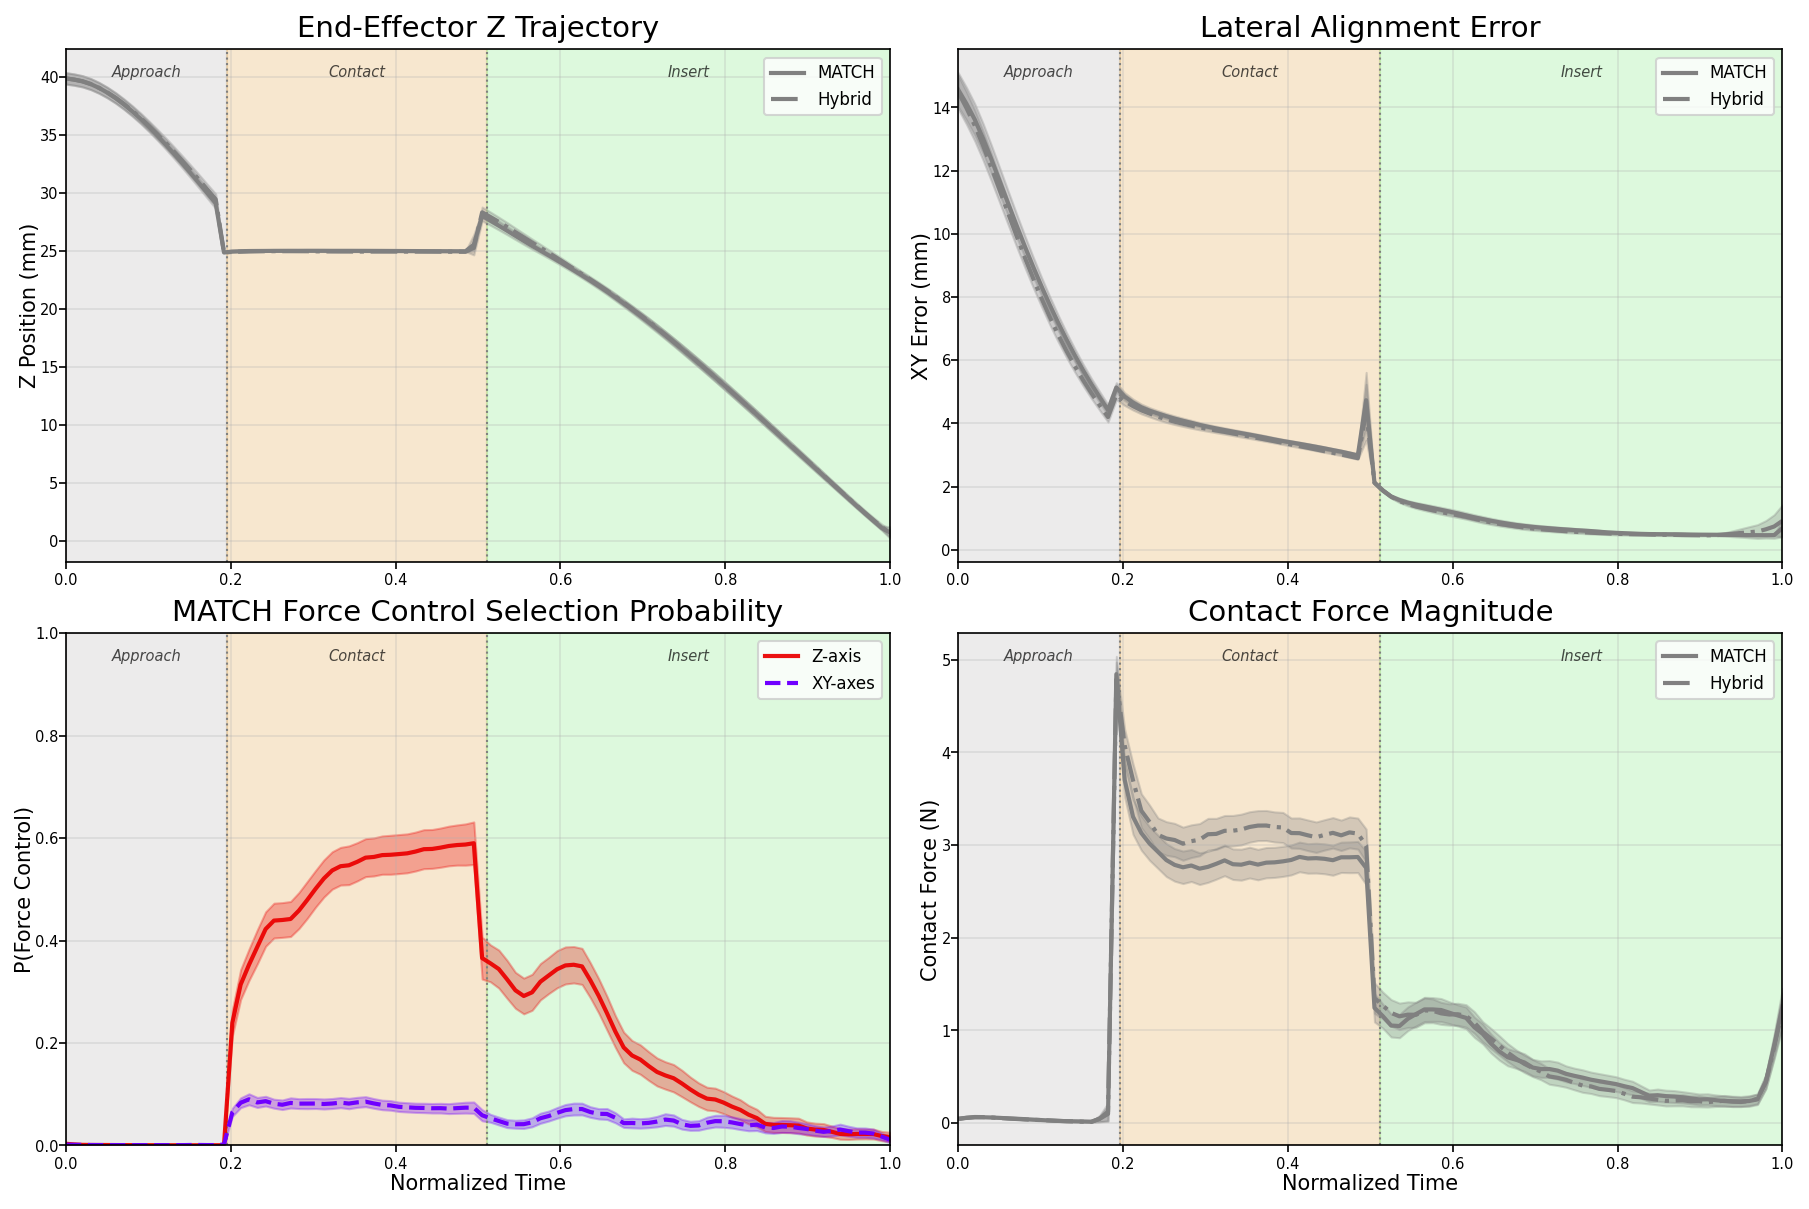

Computed phase proportions from data:
  approaching: 19.6% (avg 9.4 steps)
  initial_contact: 31.6% (avg 15.2 steps)
  insertion: 48.9% (avg 23.5 steps)


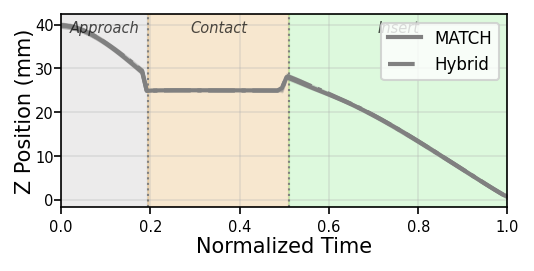

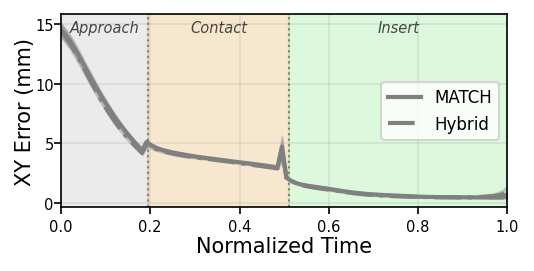

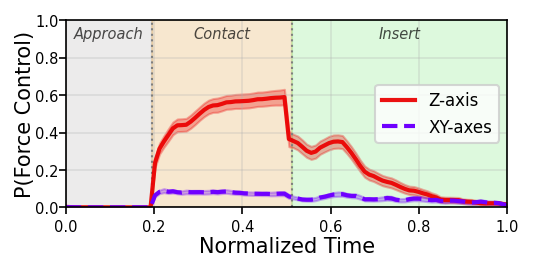

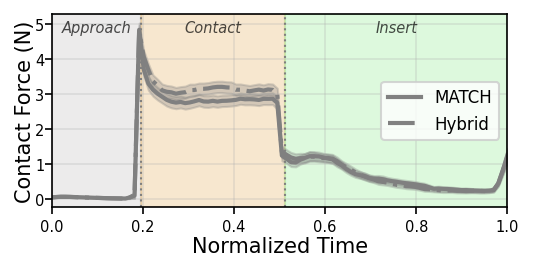

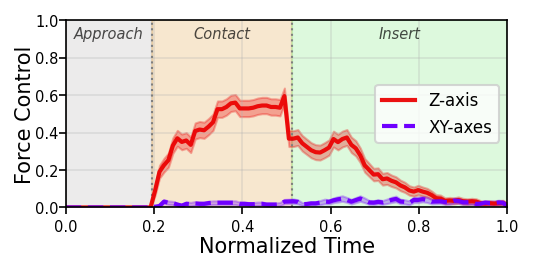

In [10]:
# ============================================================
# BLOCK 5: MULTI-PANEL TRAJECTORY PLOT (Phase-Based Normalization)
# ============================================================
#
# Generates a 2x2 multi-panel figure with phase-based normalization:
# - Each phase is normalized separately across all trajectories
# - Phase proportions are computed from average phase lengths in the data
# - Phase labels drawn directly on each phase region
# - Each subplot has its own legend for methods

import importlib
import analysis_utils
importlib.reload(analysis_utils)
from analysis_utils import (
    # Font sizes
    FONT_SUPTITLE, FONT_TITLE, FONT_AXIS_LABEL, FONT_TICK, FONT_LEGEND,
    # Plot styling
    DEFAULT_DPI, DEFAULT_FIGSIZE, TIGHT_PAD, TIGHT_W_PAD, TIGHT_H_PAD,
    AXIS_LABEL_PAD_X, AXIS_LABEL_PAD_Y, TICK_PAD_X, TICK_PAD_Y,
    LEGEND_HANDLE_LENGTH,
    # Trajectory styling
    TRAJ_PHASE_COLORS, TRAJ_PHASE_DISPLAY, TRAJ_PHASE_ALPHA,
    SELECTION_PROB_COLORS,
    TRAJ_PHASE_BOUNDARY_LINES, TRAJ_PHASE_BOUNDARY_COLOR,
    TRAJ_PHASE_BOUNDARY_LINESTYLE, TRAJ_PHASE_BOUNDARY_LINEWIDTH,
    TRAJ_PHASE_LABEL_FONTSIZE, TRAJ_PHASE_LABEL_ALPHA, TRAJ_PHASE_LABEL_Y_POS,
)

# Plot Configuration
FIGSIZE = (12, 8)
N_POINTS_TOTAL = 100  # Total points across all phases
ALPHA_FILL = 0.3  # Alpha for std fill

# Phase configuration - order of phases
PHASE_ORDER = ['approaching', 'initial_contact', 'insertion']

# Method line styles
METHOD_STYLES = {
    "Pose(1mm)": {"linestyle": "--", "linewidth": 2},
    "Hybrid-Basic": {"linestyle": "-.", "linewidth": 2},
    "MATCH(1mm)": {"linestyle": "-", "linewidth": 2},
    "Hybrid": {"linestyle": "-.", "linewidth": 2},
    "MATCH": {"linestyle": "-", "linewidth": 2},
    "LCLoP": {"linestyle": "-", "linewidth": 2},
}

# Variables to plot - with subplot titles
# 'negate': True to flip sign (for Z position and contact force)
# 'type': 'standard' for normal plot, 'selection_prob' for special selection probability plot
# 'policies': list of policies to include, or None for all
# 'ylim': optional y-axis limits
VARIABLES = [
    {'key': 'insertion_depth', 'label': 'Z Position (mm)', 'title': 'End-Effector Z Trajectory', 
     'axis': None, 'scale': 1000, 'negate': True, 'type': 'standard'},
    {'key': 'lateral_error', 'label': 'XY Error (mm)', 'title': 'Lateral Alignment Error', 
     'axis': None, 'scale': 1000, 'type': 'standard'},
    {'key': 'control_probability', 'label': 'P(Force Control)', 'title': 'MATCH Force Control Selection Probability', 
     'type': 'selection_prob', 'policies': ['MATCH(1mm)', 'MATCH'], 'ylim': (0, 1)},
    {'key': 'contact_force', 'label': 'Contact Force (N)', 'title': 'Contact Force Magnitude', 
     'axis': 2, 'scale': 1, 'negate': True, 'type': 'standard'},
    {'key': 'control_selection', 'label': 'Force Control', 'title': 'MATCH Force Control Selection', 
     'type': 'force_selection', 'policies': ['MATCH(1mm)', 'MATCH'], 'ylim': (0, 1)},
]

# ============================================================

def extract_variable(step: Dict, var_config: Dict) -> Optional[float]:
    """Extract a single value from a step based on variable config."""
    key = var_config['key']
    axis = var_config.get('axis')
    scale = var_config.get('scale', 1)
    negate = var_config.get('negate', False)
    
    val = step.get(key)
    if val is None:
        return None
    
    result = None
    if axis == 'xy':
        if isinstance(val, (list, np.ndarray)) and len(val) >= 2:
            result = np.sqrt(val[0]**2 + val[1]**2) * scale
    elif axis is not None:
        if isinstance(val, (list, np.ndarray)) and len(val) > axis:
            result = val[axis] * scale
    else:
        if isinstance(val, (list, np.ndarray)):
            result = val[0] * scale if len(val) > 0 else None
        else:
            result = val * scale
    
    if result is not None and negate:
        result = -result
    
    return result


def extract_selection_prob_z(step: Dict) -> Optional[float]:
    """Extract Z-axis selection probability."""
    val = step.get('control_probability')
    if val is None:
        return None
    if isinstance(val, (list, np.ndarray)) and len(val) > 2:
        return val[2]  # Z-axis
    return None


def extract_selection_prob_xy(step: Dict) -> Optional[float]:
    """Extract average XY selection probability."""
    val = step.get('control_probability')
    if val is None:
        return None
    if isinstance(val, (list, np.ndarray)) and len(val) >= 2:
        return (val[0] + val[1]) / 2  # Average of X and Y
    return None


def extract_force_selection_z(step: Dict) -> Optional[float]:
    """Extract Z-axis force control selection.
    
    Reads control_selection directly if available, otherwise thresholds control_probability.
    """
    sel = step.get('control_selection')
    if sel is not None and isinstance(sel, (list, np.ndarray)) and len(sel) > 2:
        return float(sel[2])
    val = step.get('control_probability')
    if val is not None and isinstance(val, (list, np.ndarray)) and len(val) > 2:
        return float(val[2] > 0.5)
    return None


def extract_force_selection_xy(step: Dict) -> Optional[float]:
    """Extract average XY force control selection.
    
    Reads control_selection directly if available, otherwise thresholds control_probability.
    """
    sel = step.get('control_selection')
    if sel is not None and isinstance(sel, (list, np.ndarray)) and len(sel) >= 2:
        return (float(sel[0]) + float(sel[1])) / 2
    val = step.get('control_probability')
    if val is not None and isinstance(val, (list, np.ndarray)) and len(val) >= 2:
        return (float(val[0] > 0.5) + float(val[1] > 0.5)) / 2
    return None


def compute_phase_proportions(episode_data: List[Dict]) -> Dict[str, float]:
    """
    Compute phase proportions based on average phase lengths across all episodes.
    
    Returns:
        Dict mapping phase name to proportion (sums to 1.0).
    """
    phase_lengths = defaultdict(list)
    
    for episode in episode_data:
        # Count steps per phase in this episode
        phase_counts = defaultdict(int)
        for step in episode['steps']:
            phase = step.get('phase', 'unknown')
            if phase in TRAJ_PHASE_COLORS:
                phase_counts[phase] += 1
        
        # Record lengths for phases that exist in this episode
        for phase in PHASE_ORDER:
            if phase in phase_counts:
                phase_lengths[phase].append(phase_counts[phase])
    
    # Compute average length for each phase
    avg_lengths = {}
    for phase in PHASE_ORDER:
        if phase in phase_lengths and len(phase_lengths[phase]) > 0:
            avg_lengths[phase] = np.mean(phase_lengths[phase])
        else:
            avg_lengths[phase] = 0
    
    # Convert to proportions
    total_length = sum(avg_lengths.values())
    if total_length == 0:
        # Fallback to equal proportions
        n_phases = len(PHASE_ORDER)
        return {phase: 1.0 / n_phases for phase in PHASE_ORDER}
    
    proportions = {phase: length / total_length for phase, length in avg_lengths.items()}
    
    # Print computed proportions
    print("Computed phase proportions from data:")
    for phase in PHASE_ORDER:
        print(f"  {phase}: {proportions[phase]:.1%} (avg {avg_lengths[phase]:.1f} steps)")
    
    return proportions


def segment_episode_by_phase(episode: Dict) -> Dict[str, List[Dict]]:
    """
    Segment an episode's steps by phase.
    
    Returns:
        Dict mapping phase name to list of steps in that phase.
    """
    segments = defaultdict(list)
    
    for step in episode['steps']:
        phase = step.get('phase', 'unknown')
        if phase in TRAJ_PHASE_COLORS:
            segments[phase].append(step)
    
    return segments


def normalize_phase_segments(
    episodes_by_policy: Dict[str, List[Dict]],
    var_config: Dict,
    phase_proportions: Dict[str, float],
    n_points_total: int = 100
) -> Dict[str, Tuple[np.ndarray, np.ndarray, np.ndarray]]:
    """
    Normalize trajectories by phase and compute mean/std for each policy.
    
    Each phase is normalized to its allocated proportion of the total points.
    
    Returns:
        Dict mapping policy name to (t, mean, std) arrays for the full normalized trajectory.
    """
    # Calculate points per phase based on proportions
    points_per_phase = {}
    for phase in PHASE_ORDER:
        points_per_phase[phase] = max(1, int(n_points_total * phase_proportions.get(phase, 0)))
    
    # Adjust to ensure total is exactly n_points_total
    total_points = sum(points_per_phase.values())
    diff = n_points_total - total_points
    if diff != 0:
        # Add/subtract from the largest phase
        largest_phase = max(points_per_phase, key=points_per_phase.get)
        points_per_phase[largest_phase] += diff
    
    # Build time axis
    t_full = np.linspace(0, 1, n_points_total)
    
    results = {}
    
    for policy, episodes in episodes_by_policy.items():
        all_trajectories = []
        
        for episode in episodes:
            segments = segment_episode_by_phase(episode)
            
            # Build normalized trajectory for this episode
            trajectory_parts = []
            
            for phase in PHASE_ORDER:
                n_points = points_per_phase.get(phase, 0)
                if n_points == 0:
                    continue
                
                if phase in segments and len(segments[phase]) > 0:
                    # Extract values for this phase
                    values = []
                    for step in segments[phase]:
                        val = extract_variable(step, var_config)
                        values.append(val if val is not None else np.nan)
                    
                    if len(values) > 1:
                        # Interpolate to allocated points
                        t_orig = np.linspace(0, 1, len(values))
                        t_target = np.linspace(0, 1, n_points)
                        interpolated = np.interp(t_target, t_orig, values)
                        trajectory_parts.append(interpolated)
                    elif len(values) == 1:
                        # Single point - repeat
                        trajectory_parts.append(np.full(n_points, values[0]))
                    else:
                        trajectory_parts.append(np.full(n_points, np.nan))
                else:
                    # Phase not present - fill with NaN
                    trajectory_parts.append(np.full(n_points, np.nan))
            
            if trajectory_parts:
                full_trajectory = np.concatenate(trajectory_parts)
                if len(full_trajectory) == n_points_total:
                    all_trajectories.append(full_trajectory)
        
        if all_trajectories:
            trajectories = np.array(all_trajectories)
            n = len(all_trajectories)
            with np.errstate(all='ignore'):
                mean = np.nanmean(trajectories, axis=0)
                std = np.nanstd(trajectories, axis=0)
            results[policy] = (t_full, mean, std, n)
    
    return results


def normalize_selection_prob_segments(
    episodes_by_policy: Dict[str, List[Dict]],
    extract_func,
    phase_proportions: Dict[str, float],
    n_points_total: int = 100
) -> Dict[str, Tuple[np.ndarray, np.ndarray, np.ndarray]]:
    """
    Normalize selection probability trajectories by phase.
    
    Similar to normalize_phase_segments but uses a custom extraction function.
    """
    # Calculate points per phase based on proportions
    points_per_phase = {}
    for phase in PHASE_ORDER:
        points_per_phase[phase] = max(1, int(n_points_total * phase_proportions.get(phase, 0)))
    
    # Adjust to ensure total is exactly n_points_total
    total_points = sum(points_per_phase.values())
    diff = n_points_total - total_points
    if diff != 0:
        largest_phase = max(points_per_phase, key=points_per_phase.get)
        points_per_phase[largest_phase] += diff
    
    # Build time axis
    t_full = np.linspace(0, 1, n_points_total)
    
    results = {}
    
    for policy, episodes in episodes_by_policy.items():
        all_trajectories = []
        
        for episode in episodes:
            segments = segment_episode_by_phase(episode)
            trajectory_parts = []
            
            for phase in PHASE_ORDER:
                n_points = points_per_phase.get(phase, 0)
                if n_points == 0:
                    continue
                
                if phase in segments and len(segments[phase]) > 0:
                    values = []
                    for step in segments[phase]:
                        val = extract_func(step)
                        values.append(val if val is not None else np.nan)
                    
                    if len(values) > 1:
                        t_orig = np.linspace(0, 1, len(values))
                        t_target = np.linspace(0, 1, n_points)
                        interpolated = np.interp(t_target, t_orig, values)
                        trajectory_parts.append(interpolated)
                    elif len(values) == 1:
                        trajectory_parts.append(np.full(n_points, values[0]))
                    else:
                        trajectory_parts.append(np.full(n_points, np.nan))
                else:
                    trajectory_parts.append(np.full(n_points, np.nan))
            
            if trajectory_parts:
                full_trajectory = np.concatenate(trajectory_parts)
                if len(full_trajectory) == n_points_total:
                    all_trajectories.append(full_trajectory)
        
        if all_trajectories:
            trajectories = np.array(all_trajectories)
            n = len(all_trajectories)
            with np.errstate(all='ignore'):
                mean = np.nanmean(trajectories, axis=0)
                std = np.nanstd(trajectories, axis=0)
            results[policy] = (t_full, mean, std, n)
    
    return results


def normalize_zoh_segments(
    episodes_by_policy: Dict[str, List[Dict]],
    extract_func,
    phase_proportions: Dict[str, float],
    n_points_total: int = 100
) -> Dict[str, Tuple[np.ndarray, np.ndarray, np.ndarray, int]]:
    """
    Normalize trajectories by phase using zero-order hold (ZOH) interpolation.
    
    Instead of linear interpolation, each target point takes the value of the
    nearest-lower source point (sample-and-hold / floor interpolation).
    """
    points_per_phase = {}
    for phase in PHASE_ORDER:
        points_per_phase[phase] = max(1, int(n_points_total * phase_proportions.get(phase, 0)))
    
    total_points = sum(points_per_phase.values())
    diff = n_points_total - total_points
    if diff != 0:
        largest_phase = max(points_per_phase, key=points_per_phase.get)
        points_per_phase[largest_phase] += diff
    
    t_full = np.linspace(0, 1, n_points_total)
    
    results = {}
    
    for policy, episodes in episodes_by_policy.items():
        all_trajectories = []
        
        for episode in episodes:
            segments = segment_episode_by_phase(episode)
            trajectory_parts = []
            
            for phase in PHASE_ORDER:
                n_points = points_per_phase.get(phase, 0)
                if n_points == 0:
                    continue
                
                if phase in segments and len(segments[phase]) > 0:
                    values = []
                    for step in segments[phase]:
                        val = extract_func(step)
                        values.append(val if val is not None else np.nan)
                    
                    if len(values) > 1:
                        t_orig = np.linspace(0, 1, len(values))
                        t_target = np.linspace(0, 1, n_points)
                        indices = np.searchsorted(t_orig, t_target, side='right') - 1
                        indices = np.clip(indices, 0, len(values) - 1)
                        zoh = np.array(values)[indices]
                        trajectory_parts.append(zoh)
                    elif len(values) == 1:
                        trajectory_parts.append(np.full(n_points, values[0]))
                    else:
                        trajectory_parts.append(np.full(n_points, np.nan))
                else:
                    trajectory_parts.append(np.full(n_points, np.nan))
            
            if trajectory_parts:
                full_trajectory = np.concatenate(trajectory_parts)
                if len(full_trajectory) == n_points_total:
                    all_trajectories.append(full_trajectory)
        
        if all_trajectories:
            trajectories = np.array(all_trajectories)
            n = len(all_trajectories)
            with np.errstate(all='ignore'):
                mean = np.nanmean(trajectories, axis=0)
                std = np.nanstd(trajectories, axis=0)
            results[policy] = (t_full, mean, std, n)
    
    return results


def get_phase_boundaries(phase_proportions: Dict[str, float]) -> List[Tuple[float, float, str]]:
    """
    Get phase boundaries as (start, end, phase_name) tuples in normalized coordinates.
    """
    boundaries = []
    cumulative = 0.0
    
    for phase in PHASE_ORDER:
        proportion = phase_proportions.get(phase, 0)
        if proportion > 0:
            start = cumulative
            end = cumulative + proportion
            boundaries.append((start, end, phase))
            cumulative = end
    
    return boundaries


def draw_phase_decorations(ax, phase_boundaries, draw_boundary_lines=TRAJ_PHASE_BOUNDARY_LINES):
    """
    Draw phase background shading, labels, and optional boundary lines on an axes.
    """
    for start, end, phase in phase_boundaries:
        color = TRAJ_PHASE_COLORS.get(phase, '#cccccc')
        display = TRAJ_PHASE_DISPLAY.get(phase, phase)

        # Background shading
        ax.axvspan(start, end, alpha=TRAJ_PHASE_ALPHA, color=color, zorder=0)

        # Phase label centered in region
        center_x = (start + end) / 2
        ax.text(
            center_x, TRAJ_PHASE_LABEL_Y_POS, display,
            transform=ax.get_xaxis_transform(),
            ha='center', va='top',
            fontsize=TRAJ_PHASE_LABEL_FONTSIZE,
            alpha=TRAJ_PHASE_LABEL_ALPHA,
            fontstyle='italic',
        )

    # Vertical boundary lines between phases
    if draw_boundary_lines:
        for i, (start, end, phase) in enumerate(phase_boundaries):
            if i > 0:  # Skip first boundary (left edge of plot)
                ax.axvline(
                    x=start,
                    color=TRAJ_PHASE_BOUNDARY_COLOR,
                    linestyle=TRAJ_PHASE_BOUNDARY_LINESTYLE,
                    linewidth=TRAJ_PHASE_BOUNDARY_LINEWIDTH,
                    zorder=2,
                )


def plot_trajectory_multipanel(
    episode_data: List[Dict],
    variables: List[Dict],
    n_points: int = 100,
    figsize: Tuple[float, float] = (12, 8),
    draw_boundary_lines: bool = TRAJ_PHASE_BOUNDARY_LINES,
) -> plt.Figure:
    """
    Create 2x2 multi-panel trajectory plot with phase-based normalization.
    """
    n_vars = len(variables)
    n_rows = 2
    n_cols = 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, dpi=DEFAULT_DPI)
    axes_flat = axes.flatten()
    
    # Compute phase proportions from data
    phase_proportions = compute_phase_proportions(episode_data)
    
    # Group episodes by policy
    episodes_by_policy = defaultdict(list)
    for ep in episode_data:
        episodes_by_policy[ep['policy']].append(ep)
    
    # Get phase boundaries
    phase_boundaries = get_phase_boundaries(phase_proportions)
    
    for ax_idx, var_config in enumerate(variables):
        if ax_idx >= len(axes_flat):
            break
        ax = axes_flat[ax_idx]
        
        # Draw phase backgrounds, labels, and boundary lines
        draw_phase_decorations(ax, phase_boundaries, draw_boundary_lines)
        
        plot_type = var_config.get('type', 'standard')
        allowed_policies = var_config.get('policies', None)
        
        if plot_type == 'selection_prob':
            filtered_episodes = {p: eps for p, eps in episodes_by_policy.items() 
                               if allowed_policies is None or p in allowed_policies}
            
            z_data = normalize_selection_prob_segments(filtered_episodes, extract_selection_prob_z, 
                                                        phase_proportions, n_points)
            for policy, (t, mean, std, n) in z_data.items():
                ci = 1.96 * std / np.sqrt(n)
                ax.plot(t, mean, color=SELECTION_PROB_COLORS['z'], linestyle='-', 
                       linewidth=2, label='Z-axis')
                ax.fill_between(t, mean - ci, mean + ci, color=SELECTION_PROB_COLORS['z'], 
                               alpha=ALPHA_FILL)
            
            xy_data = normalize_selection_prob_segments(filtered_episodes, extract_selection_prob_xy,
                                                         phase_proportions, n_points)
            for policy, (t, mean, std, n) in xy_data.items():
                ci = 1.96 * std / np.sqrt(n)
                ax.plot(t, mean, color=SELECTION_PROB_COLORS['xy'], linestyle='--', 
                       linewidth=2, label='XY-axes')
                ax.fill_between(t, mean - ci, mean + ci, color=SELECTION_PROB_COLORS['xy'], 
                               alpha=ALPHA_FILL)
        elif plot_type == 'force_selection':
            filtered_episodes = {p: eps for p, eps in episodes_by_policy.items() 
                               if allowed_policies is None or p in allowed_policies}
            
            z_data = normalize_zoh_segments(filtered_episodes, extract_force_selection_z, 
                                            phase_proportions, n_points)
            for policy, (t, mean, std, n) in z_data.items():
                ci = 1.96 * std / np.sqrt(n)
                ax.plot(t, mean, color=SELECTION_PROB_COLORS['z'], linestyle='-', 
                       linewidth=2, label='Z-axis')
                ax.fill_between(t, mean - ci, mean + ci, color=SELECTION_PROB_COLORS['z'], 
                               alpha=ALPHA_FILL)
            
            xy_data = normalize_zoh_segments(filtered_episodes, extract_force_selection_xy,
                                             phase_proportions, n_points)
            for policy, (t, mean, std, n) in xy_data.items():
                ci = 1.96 * std / np.sqrt(n)
                ax.plot(t, mean, color=SELECTION_PROB_COLORS['xy'], linestyle='--', 
                       linewidth=2, label='XY-axes')
                ax.fill_between(t, mean - ci, mean + ci, color=SELECTION_PROB_COLORS['xy'], 
                               alpha=ALPHA_FILL)
        else:
            policy_data = normalize_phase_segments(episodes_by_policy, var_config, 
                                                   phase_proportions, n_points)
            
            if allowed_policies is not None:
                policy_data = {p: data for p, data in policy_data.items() if p in allowed_policies}
            
            for policy, (t, mean, std, n) in policy_data.items():
                ci = 1.96 * std / np.sqrt(n)
                color = METHOD_COLORS.get(policy, 'gray')
                style = METHOD_STYLES.get(policy, {"linestyle": "-", "linewidth": 2})
                
                ax.plot(t, mean, color=color, label=policy, **style)
                ax.fill_between(t, mean - ci, mean + ci, color=color, alpha=ALPHA_FILL)
        
        # Configure subplot
        ax.set_title(var_config.get('title', var_config['label']), fontsize=FONT_TITLE)
        ax.set_ylabel(var_config['label'], fontsize=FONT_AXIS_LABEL, labelpad=AXIS_LABEL_PAD_Y)
        ax.tick_params(axis='x', labelsize=FONT_TICK, pad=TICK_PAD_X)
        ax.tick_params(axis='y', labelsize=FONT_TICK, pad=TICK_PAD_Y)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 1)
        
        if 'ylim' in var_config:
            ax.set_ylim(var_config['ylim'])
        
        # X-axis label on bottom row only
        row = ax_idx // n_cols
        if row == n_rows - 1:
            ax.set_xlabel('Normalized Time', fontsize=FONT_AXIS_LABEL, labelpad=AXIS_LABEL_PAD_X)
        
        # Per-subplot legend for methods
        ax.legend(fontsize=FONT_LEGEND, loc='best', handlelength=LEGEND_HANDLE_LENGTH)
    
    # Hide unused subplots
    for idx in range(n_vars, len(axes_flat)):
        axes_flat[idx].set_visible(False)
    
    plt.tight_layout(pad=TIGHT_PAD, w_pad=TIGHT_W_PAD, h_pad=TIGHT_H_PAD)
    return fig

# Generate the plot
if all_episode_data:
    fig = plot_trajectory_multipanel(
        all_episode_data,
        VARIABLES,
        n_points=N_POINTS_TOTAL,
        figsize=FIGSIZE
    )
    plt.show()
else:
    print("No episode data loaded. Please run trajectory evaluation first.")



def plot_trajectory_single(
    episode_data: List[Dict],
    var_config: Dict,
    phase_proportions: Dict[str, float],
    n_points: int = 100,
    figsize: Tuple[float, float] = DEFAULT_FIGSIZE,
    draw_boundary_lines: bool = TRAJ_PHASE_BOUNDARY_LINES,
) -> plt.Figure:
    """
    Create a single trajectory plot for one variable with phase-based normalization.
    """
    fig, ax = plt.subplots(figsize=figsize, dpi=DEFAULT_DPI)
    
    # Group episodes by policy
    episodes_by_policy = defaultdict(list)
    for ep in episode_data:
        episodes_by_policy[ep['policy']].append(ep)
    
    # Get phase boundaries
    phase_boundaries = get_phase_boundaries(phase_proportions)
    
    # Draw phase backgrounds, labels, and boundary lines
    draw_phase_decorations(ax, phase_boundaries, draw_boundary_lines)
    
    plot_type = var_config.get('type', 'standard')
    allowed_policies = var_config.get('policies', None)
    
    if plot_type == 'selection_prob':
        filtered_episodes = {p: eps for p, eps in episodes_by_policy.items() 
                           if allowed_policies is None or p in allowed_policies}
        
        z_data = normalize_selection_prob_segments(filtered_episodes, extract_selection_prob_z, 
                                                    phase_proportions, n_points)
        for policy, (t, mean, std, n) in z_data.items():
            ci = 1.96 * std / np.sqrt(n)
            ax.plot(t, mean, color=SELECTION_PROB_COLORS['z'], linestyle='-', 
                   linewidth=2, label='Z-axis')
            ax.fill_between(t, mean - ci, mean + ci, color=SELECTION_PROB_COLORS['z'], 
                           alpha=ALPHA_FILL)
        
        xy_data = normalize_selection_prob_segments(filtered_episodes, extract_selection_prob_xy,
                                                     phase_proportions, n_points)
        for policy, (t, mean, std, n) in xy_data.items():
            ci = 1.96 * std / np.sqrt(n)
            ax.plot(t, mean, color=SELECTION_PROB_COLORS['xy'], linestyle='--', 
                   linewidth=2, label='XY-axes')
            ax.fill_between(t, mean - ci, mean + ci, color=SELECTION_PROB_COLORS['xy'], 
                           alpha=ALPHA_FILL)
    elif plot_type == 'force_selection':
        filtered_episodes = {p: eps for p, eps in episodes_by_policy.items() 
                           if allowed_policies is None or p in allowed_policies}
        
        z_data = normalize_zoh_segments(filtered_episodes, extract_force_selection_z, 
                                        phase_proportions, n_points)
        for policy, (t, mean, std, n) in z_data.items():
            ci = 1.96 * std / np.sqrt(n)
            ax.plot(t, mean, color=SELECTION_PROB_COLORS['z'], linestyle='-', 
                   linewidth=2, label='Z-axis')
            ax.fill_between(t, mean - ci, mean + ci, color=SELECTION_PROB_COLORS['z'], 
                           alpha=ALPHA_FILL)
        
        xy_data = normalize_zoh_segments(filtered_episodes, extract_force_selection_xy,
                                         phase_proportions, n_points)
        for policy, (t, mean, std, n) in xy_data.items():
            ci = 1.96 * std / np.sqrt(n)
            ax.plot(t, mean, color=SELECTION_PROB_COLORS['xy'], linestyle='--', 
                   linewidth=2, label='XY-axes')
            ax.fill_between(t, mean - ci, mean + ci, color=SELECTION_PROB_COLORS['xy'], 
                           alpha=ALPHA_FILL)
    else:
        policy_data = normalize_phase_segments(episodes_by_policy, var_config, 
                                               phase_proportions, n_points)
        
        if allowed_policies is not None:
            policy_data = {p: data for p, data in policy_data.items() if p in allowed_policies}
        
        for policy, (t, mean, std, n) in policy_data.items():
            ci = 1.96 * std / np.sqrt(n)
            color = METHOD_COLORS.get(policy, 'gray')
            style = METHOD_STYLES.get(policy, {"linestyle": "-", "linewidth": 2})
            
            ax.plot(t, mean, color=color, label=policy, **style)
            ax.fill_between(t, mean - ci, mean + ci, color=color, alpha=ALPHA_FILL)
    
    # Configure plot

    ax.set_ylabel(var_config['label'], fontsize=FONT_AXIS_LABEL, labelpad=AXIS_LABEL_PAD_Y)
    ax.set_xlabel('Normalized Time', fontsize=FONT_AXIS_LABEL, labelpad=AXIS_LABEL_PAD_X)
    ax.tick_params(axis='x', labelsize=FONT_TICK, pad=TICK_PAD_X)
    ax.tick_params(axis='y', labelsize=FONT_TICK, pad=TICK_PAD_Y)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 1)
    
    if 'ylim' in var_config:
        ax.set_ylim(var_config['ylim'])
    
    # Methods legend (no phase legend - phases are labeled directly)
    ax.legend(fontsize=FONT_LEGEND, loc='best', handlelength=LEGEND_HANDLE_LENGTH)
    
    plt.tight_layout(pad=TIGHT_PAD, w_pad=TIGHT_W_PAD, h_pad=TIGHT_H_PAD)
    return fig


# Generate individual plots for each variable
FIGSIZE = (3.5, 1.75)
if all_episode_data:
    # Compute phase proportions once for all plots
    phase_proportions_single = compute_phase_proportions(all_episode_data)
    
    for var_config in VARIABLES:
        fig = plot_trajectory_single(
            all_episode_data,
            var_config,
            phase_proportions_single,
            n_points=N_POINTS_TOTAL,
            figsize=FIGSIZE
        )
        plt.show()